# Custom Follower

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import mpc.model_predictive_speed_and_steer_control as mpc
import mpc.cubic_spline_planner as sample_planner

import math
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

### get sample course

In [8]:
def get_switch_back_course(dl):
    ax = [0.0, 30.0, 6.0, 20.0, 35.0]
    ay = [0.0, 0.0, 20.0, 35.0, 20.0]
    cx, cy, cyaw, ck, s = sample_planner.calc_spline_course(
        ax, ay, ds=dl)
    ax = [35.0, 10.0, 0.0, 0.0]
    ay = [20.0, 30.0, 5.0, 0.0]
    cx2, cy2, cyaw2, ck2, s2 = sample_planner.calc_spline_course(
        ax, ay, ds=dl)
    cyaw2 = [i - math.pi for i in cyaw2]
    cx.extend(cx2)
    cy.extend(cy2)
    cyaw.extend(cyaw2)
    ck.extend(ck2)

    return cx, cy, cyaw, ck

In [9]:
dl = 1.0  # course tick
cx, cy, cyaw, ck = get_switch_back_course(dl)

### Following Properties

In [11]:
NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5  # horizon length

# mpc parameters
R = np.diag([0.01, 0.01])  # input cost matrix
Rd = np.diag([0.01, 1.0])  # input difference cost matrix
Q = np.diag([1.0, 1.0, 0.5, 0.5])  # state cost matrix
Qf = Q  # state final matrix
GOAL_DIS = 1.5  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed
MAX_TIME = 500.0  # max simulation time

# iterative paramter
MAX_ITER = 3  # Max iteration
DU_TH = 0.1  # iteration finish param

TARGET_SPEED = 10.0 / 3.6  # [m/s] target speed
N_IND_SEARCH = 10  # Search index number

DT = 0.2  # [s] time tick

# Vehicle parameters
LENGTH = 4.5  # [m]
WIDTH = 2.0  # [m]
BACKTOWHEEL = 1.0  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 1.0  # maximum accel [m/ss]

In [12]:
sp = mpc.calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)

initial_state = mpc.State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)

# t, x, y, yaw, v, d, a = do_simulation(
#     cx, cy, cyaw, ck, sp, dl, initial_state)

In [ ]:
def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state):
    goal = [cx[-1], cy[-1]]

    state = initial_state

    # initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None

    cyaw = smooth_yaw(cyaw)

    while MAX_TIME >= time:
        xref, target_ind, dref = calc_ref_trajectory(
            state, cx, cy, cyaw, ck, sp, dl, target_ind)

        x0 = [state.x, state.y, state.v, state.yaw]  # current state

        oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
            xref, x0, dref, oa, odelta)

        if odelta is not None:
            di, ai = odelta[0], oa[0]

        state = update_state(state, ai, di)
        time = time + DT

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        if check_goal(state, goal, target_ind, len(cx)):
            print("Goal")
            break


    return t, x, y, yaw, v, d, a


In [1]:
from mpc.model_predictive_speed_and_steer_control import *
import mpc.cubic_spline_planner as cubic_spline_planner

start!!


/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

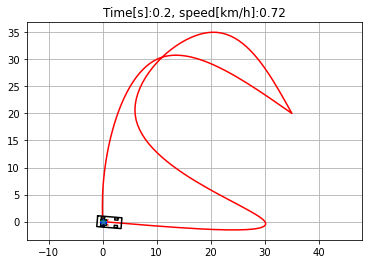

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

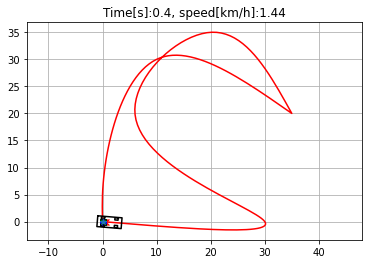

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

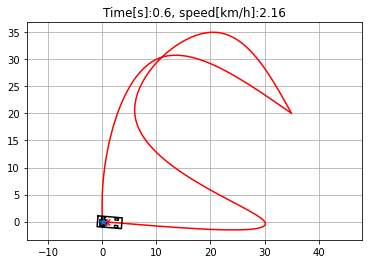

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

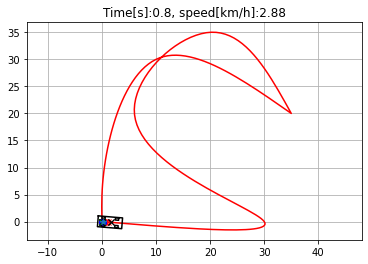

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

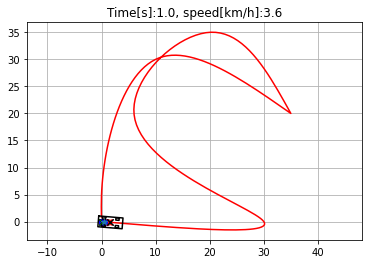

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

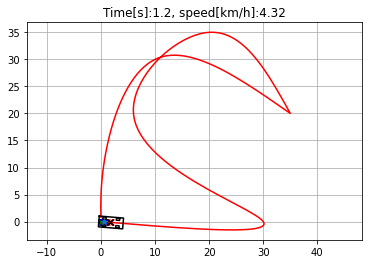

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

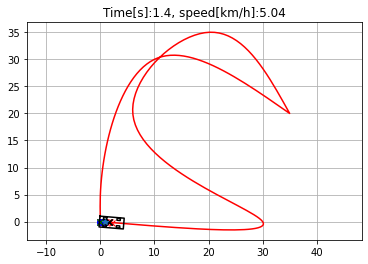

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

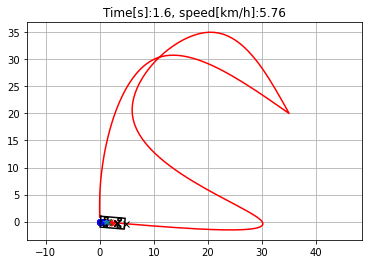

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

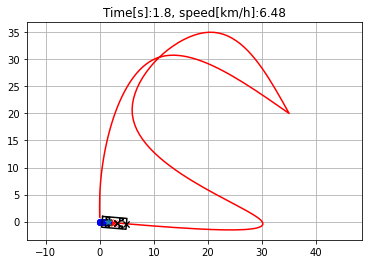

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

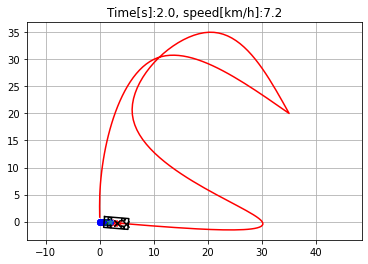

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

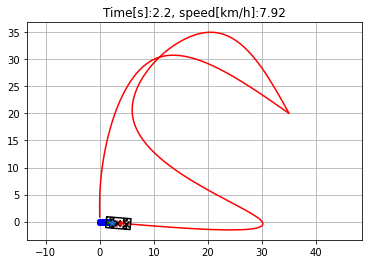

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

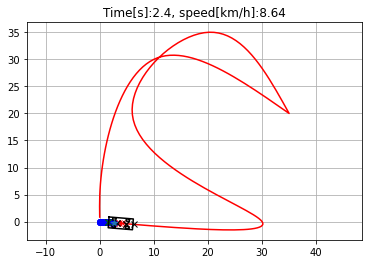

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

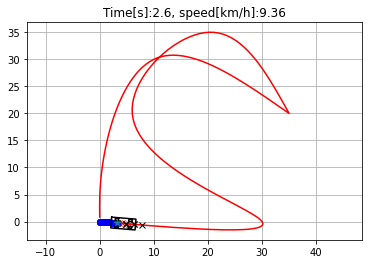

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

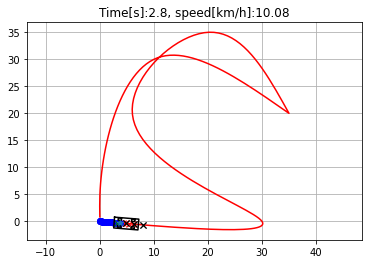

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

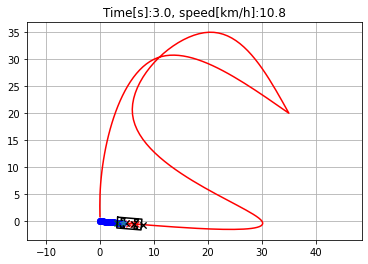

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

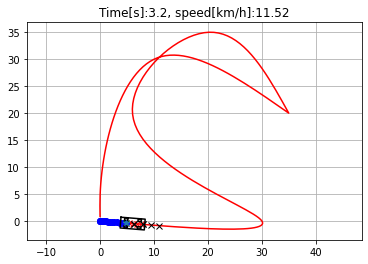

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

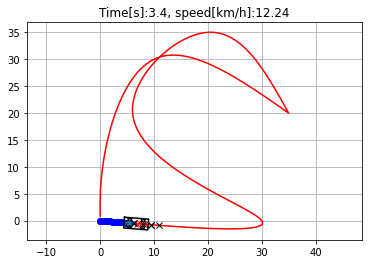

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

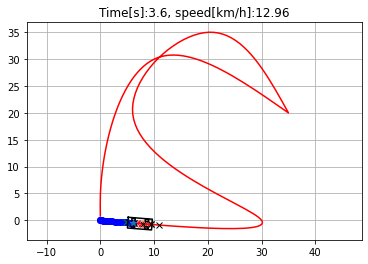

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

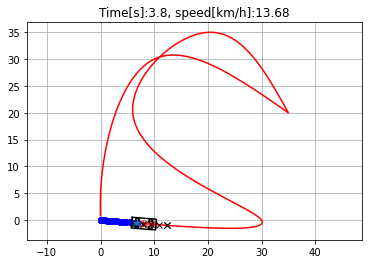

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

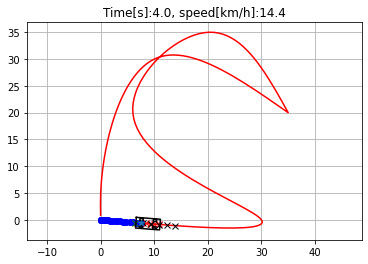

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

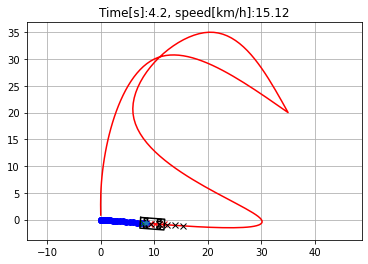

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

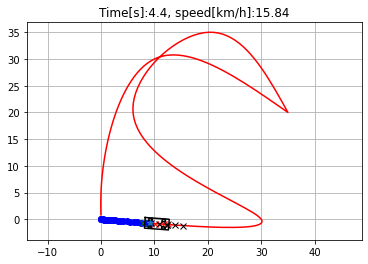

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

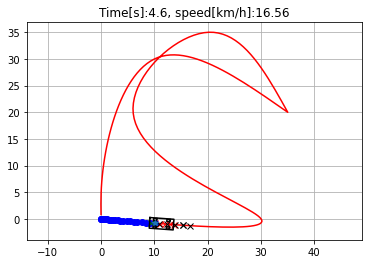

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

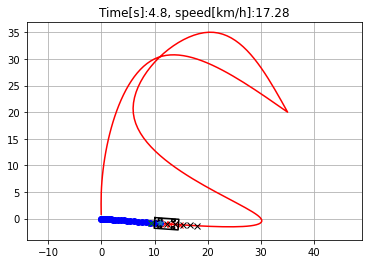

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

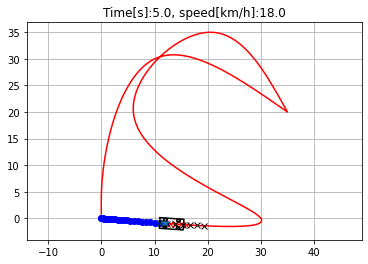

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

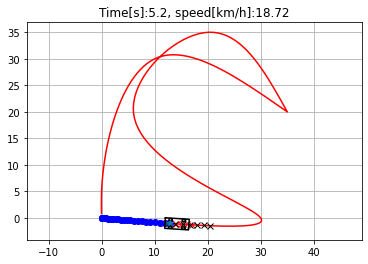

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

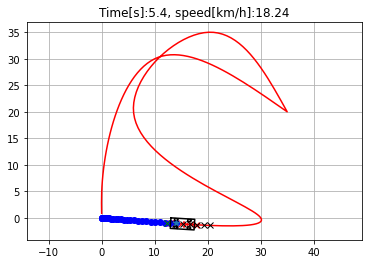

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

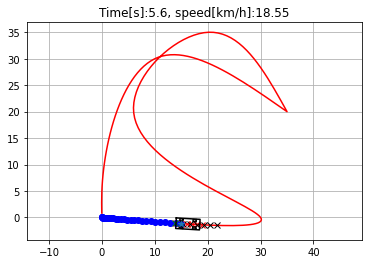

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

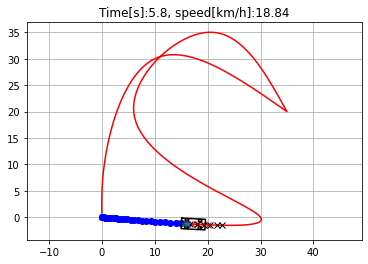

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

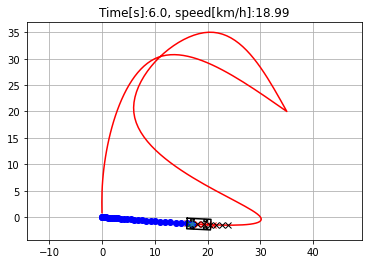

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

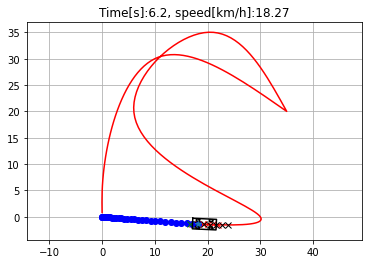

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

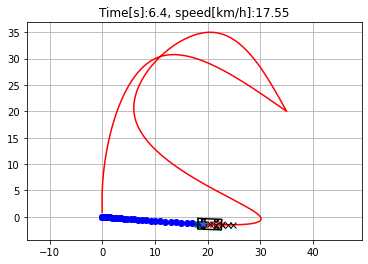

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

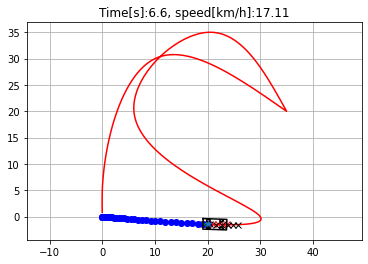

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

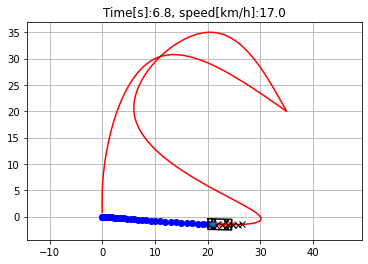

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

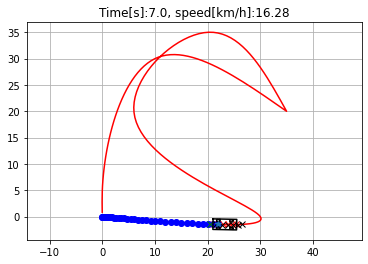

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

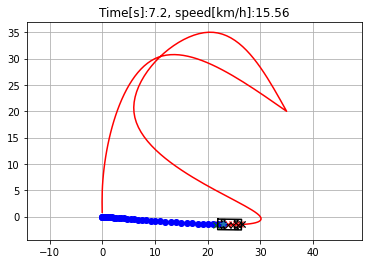

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

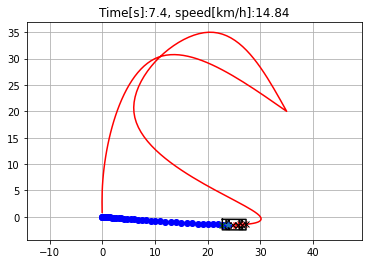

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

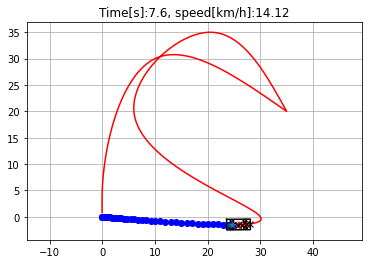

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

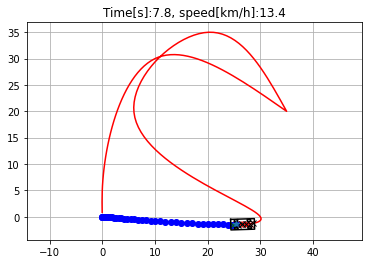

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

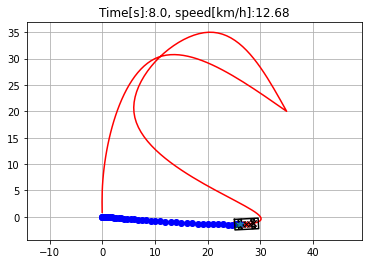

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

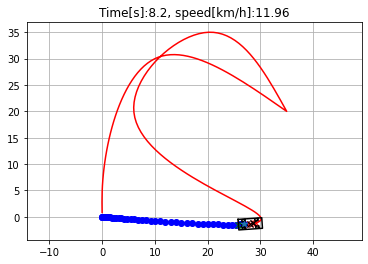

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

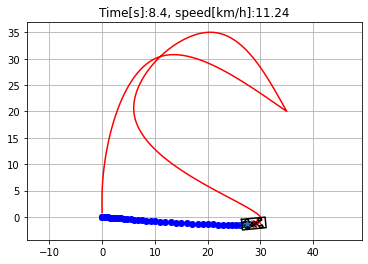

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

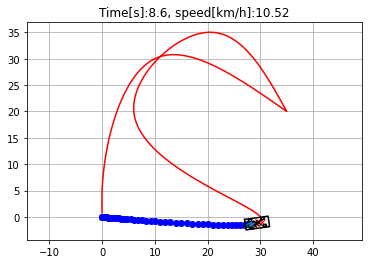

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

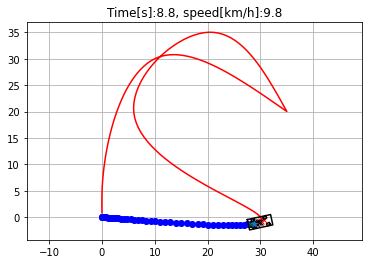

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

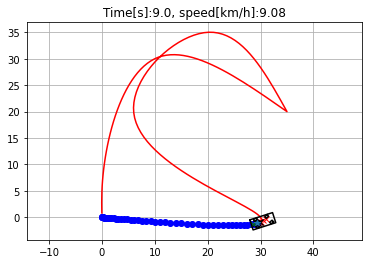

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

Iterative is max iter


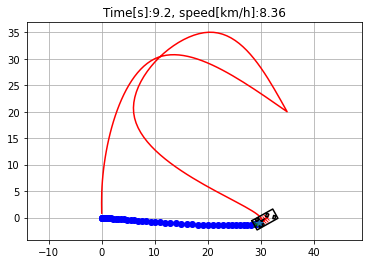

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

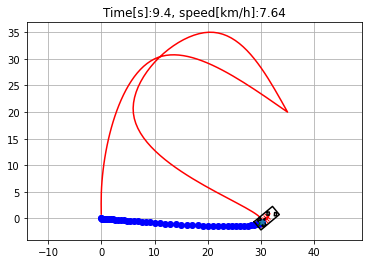

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

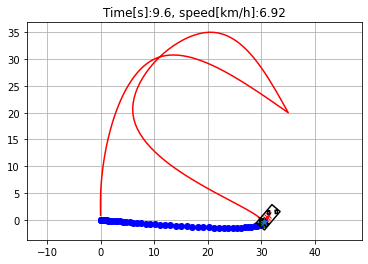

/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/q10/

KeyboardInterrupt: 

In [6]:
print("start!!")

dl = 1.0  # course tick
# cx, cy, cyaw, ck = get_straight_course(dl)
# cx, cy, cyaw, ck = get_straight_course2(dl)
# cx, cy, cyaw, ck = get_straight_course3(dl)
# cx, cy, cyaw, ck = get_forward_course(dl)
cx, cy, cyaw, ck = get_switch_back_course(dl)

sp = calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)

initial_state = State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)

t, x, y, yaw, v, d, a = do_simulation(
    cx, cy, cyaw, ck, sp, dl, initial_state)

In [5]:
def get_switch_back_course(dl):
    ax = [0.0, 30.0, 6.0, 20.0, 35.0]
    ay = [0.0, 0.0, 20.0, 35.0, 20.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)
    ax = [35.0, 10.0, 0.0, 0.0]
    ay = [20.0, 30.0, 5.0, 0.0]
    cx2, cy2, cyaw2, ck2, s2 = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)
    cyaw2 = [i - math.pi for i in cyaw2]
    cx.extend(cx2)
    cy.extend(cy2)
    cyaw.extend(cyaw2)
    ck.extend(ck2)

    return cx, cy, cyaw, ck

In [4]:
cx2

[35.0,
 33.95976077352365,
 32.9204477559058,
 31.88298715600492,
 30.84830518267951,
 29.817328044788063,
 28.790981951189057,
 27.770193110740994,
 26.75588773230236,
 25.74899202473164,
 24.750432196887328,
 23.761134457627914,
 22.782025015811886,
 21.814030080297734,
 20.85807585994395,
 19.91508856360901,
 18.985994400151426,
 18.07171957842968,
 17.17319030730225,
 16.29133279562764,
 15.42707325226433,
 14.581337886070813,
 13.755052905905583,
 12.949144520627126,
 12.164538939093926,
 11.402162370164483,
 10.662941022697282,
 9.947801041143363,
 9.257473225805729,
 8.592062136179576,
 7.951547094989254,
 7.3359074249591325,
 6.74512244881357,
 6.179171489276925,
 5.6380338690735625,
 5.121688910927843,
 4.630115937564126,
 4.163294271706772,
 3.7212032360801466,
 3.303822153408606,
 2.911130346416516,
 2.5431071378282333,
 2.199731850368123,
 1.880983806760542,
 1.5868423297298542,
 1.3172867420004226,
 1.0722963662966043,
 0.8518505253427621,
 0.6559285418632596,
 0.484509738

In [ ]:
def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state):
    """
    Simulation

    cx: course x position list
    cy: course y position list
    cy: course yaw position list
    ck: course curvature list
    sp: speed profile
    dl: course tick [m]

    """

    goal = [cx[-1], cy[-1]]

    state = initial_state

    # initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None

    cyaw = smooth_yaw(cyaw)

    while MAX_TIME >= time:
        xref, target_ind, dref = calc_ref_trajectory(
            state, cx, cy, cyaw, ck, sp, dl, target_ind)

        x0 = [state.x, state.y, state.v, state.yaw]  # current state

        oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
            xref, x0, dref, oa, odelta)

        if odelta is not None:
            di, ai = odelta[0], oa[0]

        state = update_state(state, ai, di)
        time = time + DT

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        if check_goal(state, goal, target_ind, len(cx)):
            print("Goal")
            break

        if show_animation:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])
            if ox is not None:
                plt.plot(ox, oy, "xr", label="MPC")
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(xref[0, :], xref[1, :], "xk", label="xref")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plot_car(state.x, state.y, state.yaw, steer=di)
            plt.axis("equal")
            plt.grid(True)
            plt.title("Time[s]:" + str(round(time, 2))
                      + ", speed[km/h]:" + str(round(state.v * 3.6, 2)))
            plt.pause(0.0001)

    return t, x, y, yaw, v, d, a


In [ ]:
def update_state(state, a, delta, dt):
    if delta >= MAX_STEER:
        delta = MAX_STEER
    elif delta <= -MAX_STEER:
        delta = -MAX_STEER
    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / WB * math.tan(delta) * dt
    state.v = state.v + a * dt
    if state.v > MAX_SPEED:
        state.v = MAX_SPEED
    elif state.v < MIN_SPEED:
        state.v = MIN_SPEED
    return state